# Multivariate Linear Regression

## Introduction

In this notebook, we will explore the use of linear regression, a foundational supervised learning technique, to predict employee salaries based on their characteristics. By analyzing the data, we aim to determine how a combination of some features can explain variations in employee salaries and evaluate the performance of the model on unseen data.

To achieve this, we will work with two datasets: the main salary data (salary.csv) and its [metadata](https://github.com/PhumlaniKubeka/StatisticalThinking/blob/master/Salary%20metadata.csv) to guide our understanding of the variables.

Investigating the dataset for missing values, extreme values, and variable distributions. Visualizing data relationships with histograms and scatterplots.Assessing whether the data meets the assumptions of linear regression and identifying potential data transformations.

Fitting a simple linear regression model using identified features as predictors for Salary.
Evaluating the model’s statistical significance and explanatory power using metrics such as `R^2` and `p-value`. Interpreting the regression coefficients to understand the relationship between features and salary.

Evaluating the model's performance on both training and test datasets, including calculating the `Root Mean Square Error (RMSE)` to detect overfitting. This notebook will provide a practical foundation in using linear regression for predictive analytics while highlighting the importance of careful data examination and interpretation

## Importing libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import pearsonr, shapiro

## Load dataset


In [2]:
salary_df = pd.read_csv("../data/salary.csv")

The dataset has been loaded and stored in the variable named `salary_df`.

## Exploratory data analysis 

In [3]:
salary_df.head()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,Field,yearsabs
0,53000.0,0,0,0,1.17,1,0,1,1,3,0
1,58000.0,1,0,0,1.24,1,0,1,1,2,0
2,45500.0,0,0,0,1.21,1,0,1,1,3,2
3,35782.0,0,2,1,0.99,1,0,1,1,4,1
4,34731.0,0,2,2,0.91,1,0,1,1,4,1


The dataset appears to relate people's salaries to factors that may influence their annual earnings.

In [4]:
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   salary       513 non-null    float64
 1   exprior      514 non-null    int64  
 2   yearsworked  514 non-null    int64  
 3   yearsrank    514 non-null    int64  
 4   market       514 non-null    float64
 5   degree       514 non-null    int64  
 6   otherqual    514 non-null    int64  
 7   position     514 non-null    int64  
 8   male         514 non-null    int64  
 9   Field        514 non-null    int64  
 10  yearsabs     514 non-null    int64  
dtypes: float64(2), int64(9)
memory usage: 44.3 KB


The dataset contains 11 columns and 514 rows. Only the "salary" and "market" columns are of the float data type, while all other columns are integers. There is only one null value in the "salary" column.

In [5]:
def category_and_column_cleaning(df):
    new_df = df.copy()
    new_df["degree"] = new_df["degree"].replace({0: "No", 1: "Yes"}).astype("category")
    new_df["otherqual"] = (
        new_df["otherqual"].replace({0: "No", 1: "Yes"}).astype("category")
    )
    new_df["position"] = pd.Categorical(
        new_df["position"].replace(
            {1: "Junior employee", 2: "Manager", 3: "Executive"}
        ),
        categories=["Junior employee", "Manager", "Executive"],
        ordered=True,
    )
    new_df["male"] = new_df["male"].replace({0: "Female", 1: "Male"}).astype("category")
    new_df["Field"] = (
        new_df["Field"]
        .replace({1: "Engineering", 2: "Finance", 3: "Human resources", 4: "Marketing"})
        .astype("category")
    )
    new_df.columns = [
        "Annual salary",
        "Years of experince in prior field",
        "Years worked in current field",
        "Years worked at current rank",
        "Market value",
        "Has degree",
        "Has other post-secondary qualification",
        "Position",
        "Gender",
        "Field",
        "Years absent from work",
    ]
    return new_df


cleaned_df = category_and_column_cleaning(salary_df)

A function named `category_and_column_cleaning` has been created to convert certain columns and responses into meaningful data for better readability. This transformation aligns with the dataset's metadata. The resulting dataset is stored in `cleaned_df`.

In [6]:
cleaned_df.head()

,Annual salary,Years of experince in prior field,Years worked in current field,Years worked at current rank,Market value,Has degree,Has other post-secondary qualification,Position,Gender,Field,Years absent from work
0,53000.0,0,0,0,1.17,Yes,No,Junior employee,Male,Human resources,0
1,58000.0,1,0,0,1.24,Yes,No,Junior employee,Male,Finance,0
2,45500.0,0,0,0,1.21,Yes,No,Junior employee,Male,Human resources,2
3,35782.0,0,2,1,0.99,Yes,No,Junior employee,Male,Marketing,1
4,34731.0,0,2,2,0.91,Yes,No,Junior employee,Male,Marketing,1


The dataset is as expected. It now clearly indicates the field each individual works in, their gender, and whether they have a degree or other qualifications beyond secondary school.

In [7]:
cleaned_df.describe().round(2)

,Annual salary,Years of experince in prior field,Years worked in current field,Years worked at current rank,Market value,Years absent from work
count,513.00,514.00,514.00,514.00,514.00,514.00
mean,50863.22,2.93,12.85,7.05,0.95,6.98
std,12685.13,4.79,9.44,6.41,0.15,16.87
min,29000.00,0.00,0.00,0.00,0.71,0.00
25%,40000.00,0.00,4.00,2.00,0.84,0.00
50%,50096.00,0.50,12.00,5.00,0.92,1.00
75%,60345.00,4.00,22.00,12.00,1.02,2.00
max,96156.00,25.00,41.00,28.00,1.33,118.00


**Annual salary:**
- Has one count less than any other column, suggesting a null value in the entries.
- Mean salary: `$50,863.22`
- Range: `$29,000` (min) to `$96,156` (max)
- Standard deviation: `$12,685.13`, indicates moderate variability in salary across individuals.
- Median salary (`$50,096`) is close to the mean, suggesting no extreme skewness in salary distribution.
- Quartiles show that 50% of salaries fall between `$40,000` and `$60,345`.

**Years of experince in prior field:**
 - Mean prior experience: 2.93 years, ranging from 0 to 25 years.
 - About 50% of individuals have no prior experience (25th percentile = 0, median = 0).
 - Indicates that many employees started fresh in their current roles.

**Years worked in current field:**
 - Mean: 12.85 years, with a range from 0 to 41 years.
 - Standard deviation: 9.44 years, indicating substantial variability in experience.
 - The median (12 years) and quartiles show that the distribution is not strongly skewed.

**Years worked at current rank:**
 - Mean rank years: 7.05 years.
 - Range: 0 to 28 years, with a median of 5 years.
 - Employees generally spend considerable time advancing their ranks.

**Market:**
 - Mean value: 0.95, with a narrow standard deviation (0.15).
 - The range from 0.71 to 1.33 suggests this might be a scaling variable for market competitiveness or demand in specific roles.

**Years absent from work:**
 - Mean: 6.98 years, but a wide range from 0 to 118 years absent.
 - High variability (std: 16.87), with extreme outliers likely influencing the mean.
 - Median (1 year) and 75th percentile (2 years) suggest most employees have limited absences, but outliers significantly impact the distribution.


In [8]:
cleaned_df.describe(exclude=np.number)

,Has degree,Has other post-secondary qualification,Position,Gender,Field
count,514,514,514,514,514
unique,2,2,3,2,4
top,Yes,No,Executive,Male,Marketing
freq,496,491,211,386,136


**Has degree:**
- Categories: Yes (has a degree) and No (no degree).
- Most common category (top): Yes (496 employees).
- The majority of employees hold a degree, with only 18 employees lacking one. This suggests that having a degree might be a significant factor in employment or promotion within the organization.

**Has other post-secondary qualification:**
- Categories: Yes (has additional qualifications) and No (no additional qualifications).
- Most common category (top): No (491 employees).
- Few employees have additional qualifications beyond their primary degree. This could indicate that extra qualifications are not a common or necessary requirement in the organization.

**Position:**
- Categories: Executive, Manager, Staff (3 unique positions).
-  Most common position (top): Executive (211 employees).
- Executives make up the largest group in the organization.

**Gender:**
- Categories: Male and Female.
- Most common category (top): Male (386 employees).
- The workforce is predominantly male, with 386 men compared to 128 women. Gender imbalance may be present in this organization.

**Field:**
- Categories: Marketing, HR, Finance, Other (4 unique fields).
- Most common field (top): Marketing (136 employees).
- Marketing has the highest representation, which might indicate the organization's focus or emphasis on marketing roles. HR, Finance, and other fields are less represented.

### Data validation

In [9]:
def are_all_numeric_non_negative(df):
    numeric_df = df.select_dtypes(include=["number"])
    numeric_df.dropna(axis=0, inplace=True)
    return (numeric_df >= 0).all().all()


are_all_numeric_non_negative(cleaned_df)

True

All numeric values in the dataset are non-negative, as expected, when the row with the null value is excluded. This logic is based on the fact that no one can earn a negative salary or have a negative number of years of experience. Similarly, market value cannot be negative, as that would imply an employee earning less than zero.

To verify data consistency, an assertion is made to ensure that the years worked in the field are greater than or equal to the years spent at the current rank. This logic is based on the premise that an individual cannot have spent less time in their field than they have at their current rank within that field.

In [10]:
def years_worked_validation(df):
    assert (
        df["Years worked in current field"] >= df["Years worked at current rank"]
    ).all(), "Validation failed: 'Years worked in current field' contains values less than 'Years worked at current rank'."


years_worked_validation(cleaned_df)

The verification passed without any issues.

In [11]:
def years_absent(df):
    condition = (
        df["Years of experince in prior field"] + df["Years worked in current field"]
        < df["Years absent from work"]
    )
    return np.sum(condition)


years_absent(cleaned_df)

96

There are 96 instances where the years absent exceed the total of years worked in the current field and years worked in a prior field. This discrepancy raises concerns, prompting further investigation into the "Years absent from work" column.

In [12]:
cleaned_df.sort_values("Years absent from work", ascending=False).head()

,Annual salary,Years of experince in prior field,Years worked in current field,Years worked at current rank,Market value,Has degree,Has other post-secondary qualification,Position,Gender,Field,Years absent from work
385,63144.0,14,27,20,0.73,Yes,No,Executive,Male,Human resources,118
513,52662.0,13,25,11,0.78,Yes,No,Executive,Female,Engineering,112
512,56542.0,8,20,10,0.78,Yes,No,Executive,Female,Finance,78
511,53187.0,19,7,6,0.78,Yes,No,Executive,Female,Marketing,76
510,60402.0,6,19,7,0.86,Yes,No,Executive,Female,Engineering,72


It has been observed that the "years absent" column contains values exceeding 70 years for the top five candidates, which is inconsistent with the average human life expectancy. This suggests that the values in this column are unlikely to represent years. Furthermore, interpreting these values as months would imply that the top five respondents were cumulatively absent for over five years, which also seems improbable. This raises the possibility that the column represents either weeks or days.

In [13]:
cleaned_df[cleaned_df["Years absent from work"] == 0].sort_values(
    "Years worked in current field", ascending=False
).head()

,Annual salary,Years of experince in prior field,Years worked in current field,Years worked at current rank,Market value,Has degree,Has other post-secondary qualification,Position,Gender,Field,Years absent from work
382,64109.00,0,41,28,0.91,Yes,No,Executive,Male,Finance,0
364,66334.00,0,35,23,0.78,Yes,No,Executive,Male,Engineering,0
365,82508.00,0,32,23,0.93,No,Yes,Executive,Male,Finance,0
360,69827.75,0,30,21,0.79,Yes,No,Executive,Male,Engineering,0
353,69976.00,0,30,14,0.91,Yes,No,Executive,Male,Engineering,0


It has been observed that some values in the "years absent" column are equal to zero for individuals who have been working for over 30 years. This further challenges the idea that the values represent weeks or days, as such scenarios are highly unlikely. Given this, it seems reasonable to drop the column, as the data it contains does not appear to be meaningful or reliable.

In [14]:
cleaned_df.drop("Years absent from work", axis=1, inplace=True)

The column 'Years absent from work' has been dropped.

In [15]:
cleaned_df[cleaned_df["Annual salary"].isnull()]

,Annual salary,Years of experince in prior field,Years worked in current field,Years worked at current rank,Market value,Has degree,Has other post-secondary qualification,Position,Gender,Field
208,NaN,0,21,10,0.93,Yes,No,Executive,Male,Marketing


The null value contained at annual salary has been identified and will filled using the market value, field and position.

In [16]:
filler_salary = (
    0.93
    * cleaned_df.loc[
        (cleaned_df["Position"] == "Executive") & (cleaned_df["Field"] == "Marketing")
    ]["Annual salary"].mean()
)

`filler_salary` has been defined by multiplying the market value with the average salary of executives in the marketing field. This approach is likely to provide the best estimate for the missing salary.

In [17]:
cleaned_df["Annual salary"] = cleaned_df["Annual salary"].fillna(filler_salary)

The null value has been filled.

In [18]:
cleaned_df.isnull().sum().sum()

0

There are no longer any null values present in the dataset.

A function will be created for generating graphs and visualizations to ensure that the code is not repetitive and can be reused efficiently. This will streamline the process and enhance the maintainability of the code.

In [19]:
def relationship_graph(column, x_units=None):
    if all(isinstance(entry, str) for entry in cleaned_df[column]):
        plt.figure(figsize=(10, 6))
        sns.histplot(
            data=cleaned_df,
            x="Annual salary",
            hue=column,
            kde=True,
            bins=10,
            edgecolor="black",
            alpha=0.7,
        )
        plt.title(f"Annual salary distribution by {column}", weight="bold", fontsize=14)
        plt.xlabel("Annual salary", weight="bold", fontsize=12)
        plt.ylabel("Frequency", weight="bold", fontsize=12)
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(
            data=cleaned_df, x=column, y="Annual salary", alpha=0.7, edgecolor="black"
        )
        plt.title(f"Annual salary vs {column}", weight="bold", fontsize=14)
        if x_units:
            plt.xlabel(f"{column} (in {x_units})", weight="bold", fontsize=12)
        else:
            plt.xlabel(f"{column}", weight="bold", fontsize=12)
        plt.xlim(
            0,
            max(cleaned_df[column]) + cleaned_df[column].min() / 2,
        )
        plt.ylim(
            0, max(cleaned_df["Annual salary"]) + cleaned_df["Annual salary"].min() / 2
        )
        plt.ylabel("Annual salary (in $)", weight="bold", fontsize=12)
        plt.tight_layout()
        plt.show()

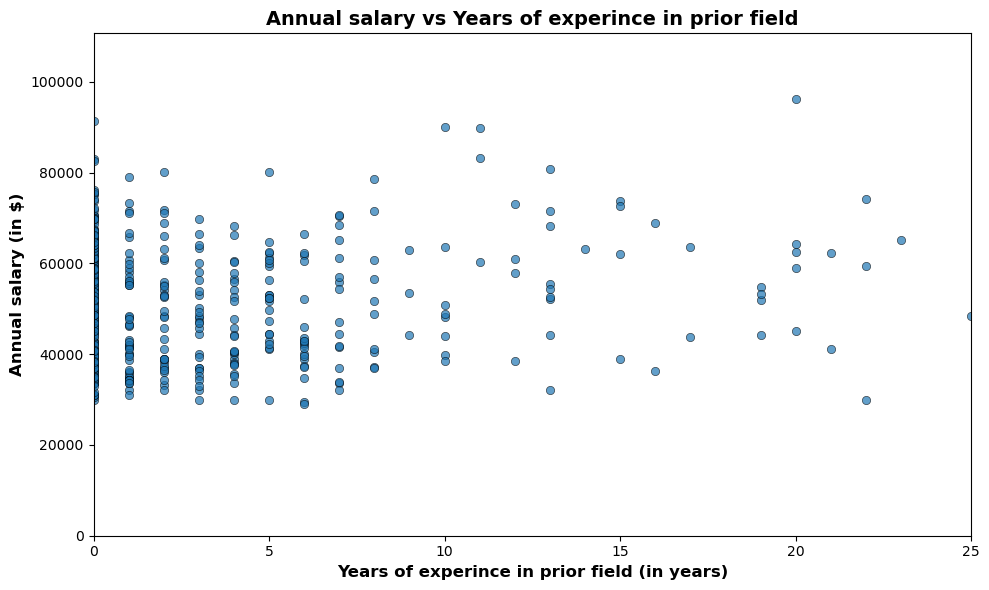

In [20]:
relationship_graph("Years of experince in prior field", "years")

There is a high density of data points between 0 to 5 years of experience, indicating that many employees have limited prior experience. Salaries in this range vary widely, from around `$30,000` to above `$70,000`.

While some higher salaries are associated with more years of experience, the trend is not strictly increasing.
This suggests that prior experience alone may not strongly dictate salary—other factors like job role, industry, or skills could be at play.

Fewer data points exist for those with more than 10 years of prior experience. Salaries at these experience levels still show variability, with some high earners above `$90,000`.

Some salaries above `$90,000` might be outliers, as they are significantly higher than most points. There are also a few low salaries beyond 20 years of experience, which could indicate industry shifts or career changes.

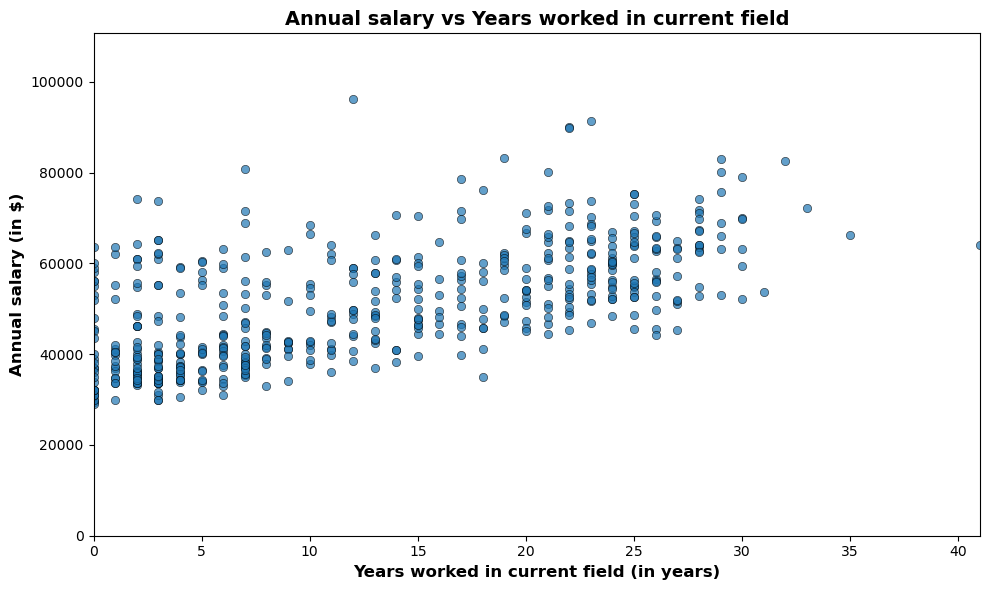

In [21]:
relationship_graph("Years worked in current field", "years")

There is a positive correlation between annual salary and  years worked in current field. This graph suggests a clear upward trend—more years in the current field generally lead to higher salaries. This aligns with expectations, as experience in the same field tends to have a stronger impact on salary growth.

There is a huge variability in the salary of individuals at the same number of years worked in the field. Some individuals with 30+ years of experience still have salaries around `$40,000–$50,000`, which could indicate factors like  job role differences. A few high earners above $90,000 exist at different experience levels, potentially reflecting promotions or executive roles.

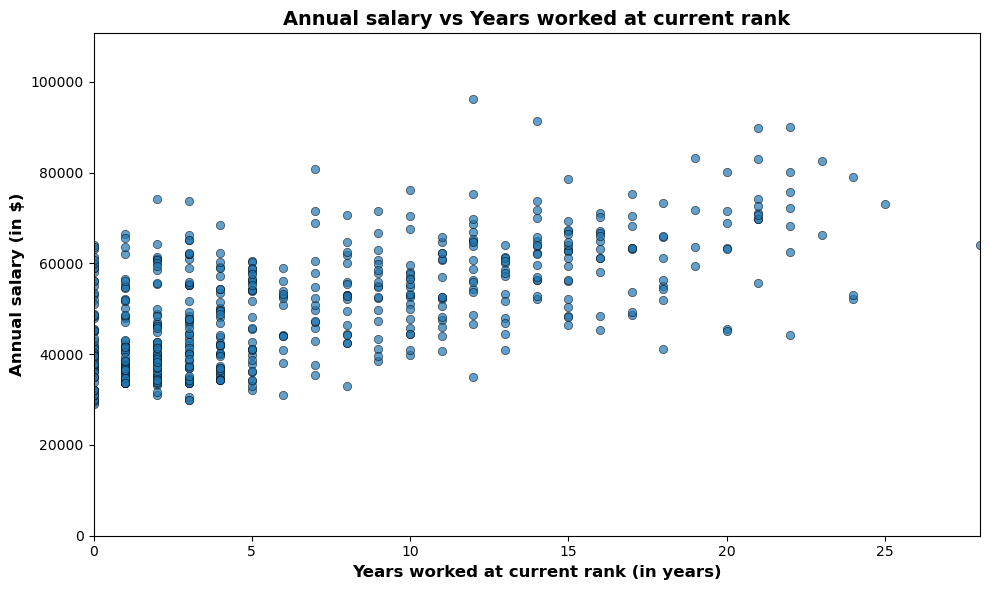

In [22]:
relationship_graph("Years worked at current rank", "years")

There is a general upward trend in the data, suggesting that as employees spend more years at their current rank, their salary tends to increase. However, the relationship is not perfectly linear.At almost every experience level, there is a wide range of salaries. This suggests that factors beyond just tenure, such as performance, department, education, and promotions, may influence salary.

A significant number of data points are concentrated at lower years of experience (0-5 years), indicating that most employees have spent relatively few years at their current rank. Some individuals with moderate years of experience (e.g., 10-15 years) earn significantly higher salaries than their peers, indicating possible promotions, specialized roles, or bonuses. While salaries increase with experience, the rate of increase seems to slow down after approximately 15-20 years, which may indicate salary stagnation at higher ranks.

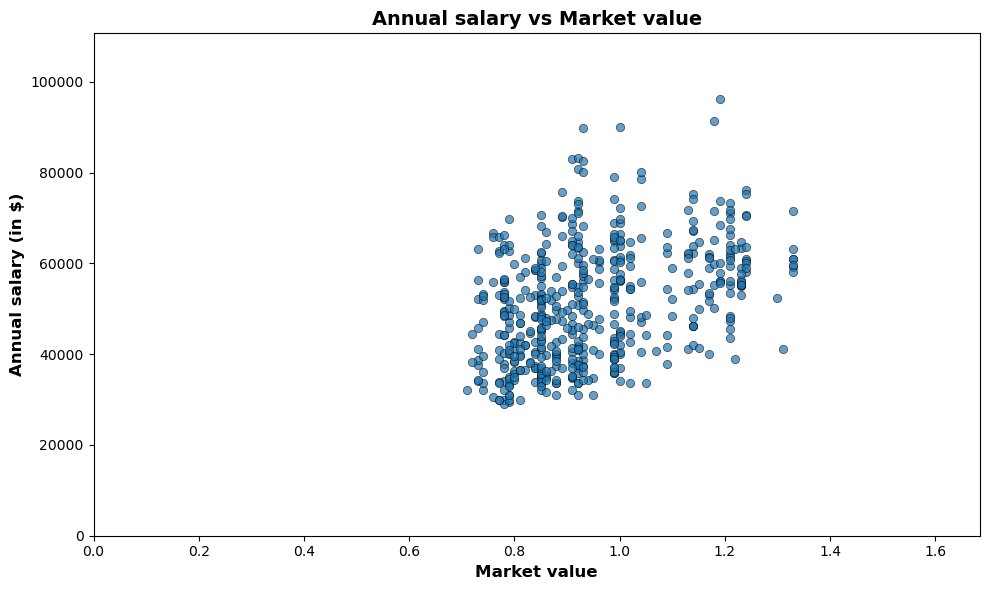

In [23]:
relationship_graph("Market value")

There seems to be a slight upward trend, suggesting that employees with higher market value tend to have higher salaries. However, the relationship is not very strong, indicating that market value alone does not fully determine salary. Salaries are widely spread at nearly all market value levels, meaning employees with similar market values can have vastly different salaries. This may be due to factors like job roles, experience, negotiation, or company policies.

Certain market values (e.g., around 0.8 to 1.0) have a high density of data points, indicating that many employees fall within these market value ranges.There are some individuals with significantly higher salaries compared to their peers with similar market values, suggesting that factors such as performance bonuses, leadership roles, or promotions may play a role.

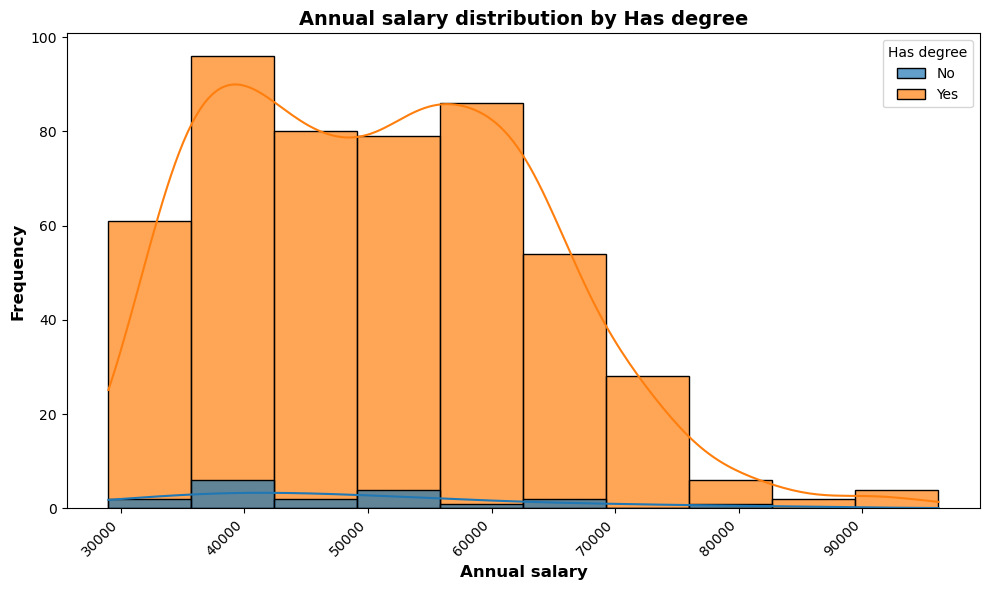

In [24]:
relationship_graph("Has degree")

The majority of employees hold a degree compared to those without one. The salary distribution for degree holders shows a much higher density in the middle-to-upper salary ranges.

Salaries for degree holders range widely, from around `$30,000` to over `$90,000`. In contrast, salaries for non-degree holders are more concentrated in the low-to-middle salary ranges, with fewer instances of higher earnings.

The distribution displays a long tail on the right, indicating that while most salaries are clustered in the middle range (e.g., `$40,000` to `$60,000`), there are a few employees earning significantly higher salaries.

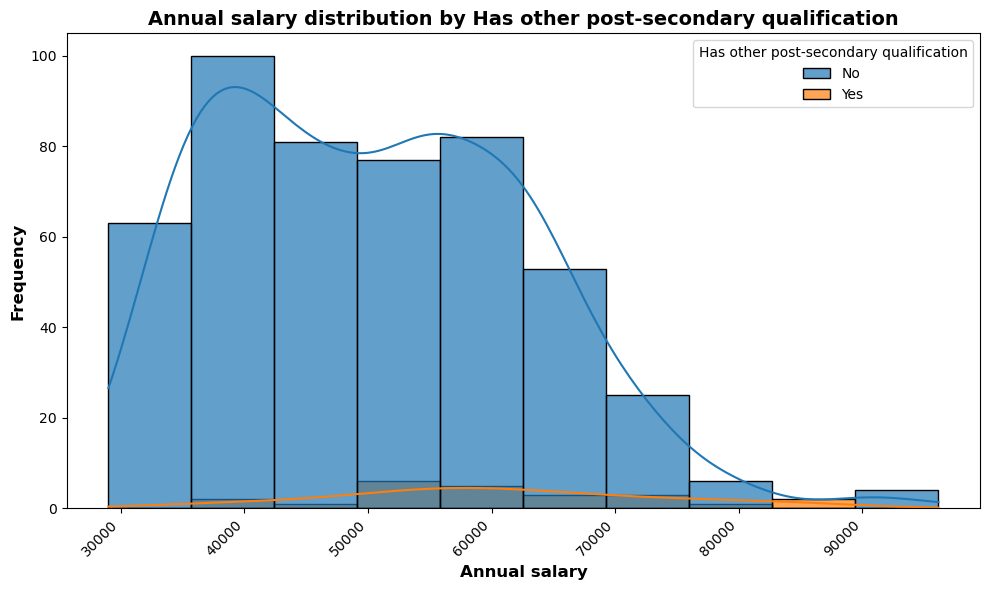

In [25]:
relationship_graph("Has other post-secondary qualification")

The "No" (Has other post-secondary qualifications) group exhibits a bimodal distribution, suggesting two distinct subpopulations:

1. A larger peak around the `$40,000-$50,000` range, likely representing entry-level or less specialized roles.
2. A smaller peak around the `$60,000-$70,000` range, which may indicate individuals who have progressed in their careers or acquired valuable skills through experience, despite lacking additional formal qualifications.

Both distributions appear slightly right-skewed, a common trait in income data, indicating that while most individuals earn within a certain range, there are a few outliers at the higher end, pulling the mean salary upwards.

The "Yes" (Has other post-secondary qualifications) group shows a flatter and less pronounced distribution. While it's harder to pinpoint clear peaks, the KDE suggests a more even spread across the salary range. The key takeaway is that having "other post-secondary qualifications" seems to reduce the likelihood of being in the lower salary range while slightly increasing the probability of being in the higher salary range.

It's important to note the significant difference in sample sizes between the two groups. The "No" group has a much higher frequency in most bins, indicating a larger sample size. This is crucial when interpreting the results, as smaller sample sizes may lead to less reliable conclusions.

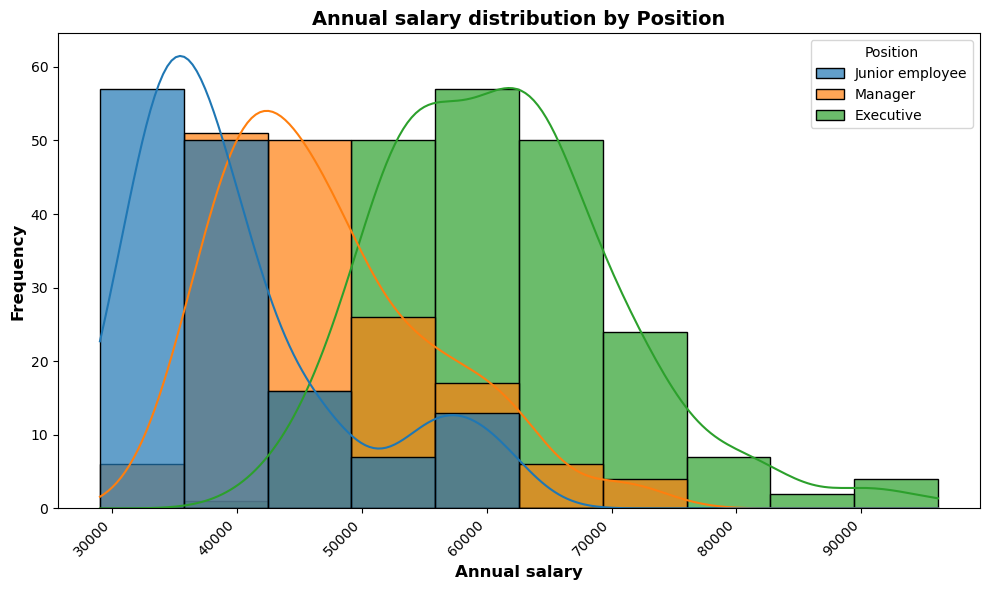

In [26]:
relationship_graph("Position")

Junior Employees have the lowest salary range, concentrated around `$30,000–$45,000`. Managers earn higher salaries, mostly between `$40,000–$55,000`. Executives have the highest salaries, spanning a broader range, from around `$50,000` to `$90,000`, with a peak around `$60,000–$70,000`.

There is some overlap between the salary distributions of Managers and Executives in the `$50,000–$60,000` range. Junior Employees and Managers overlap between `$35,000–$45,000`, but Managers still earn slightly more. Executives' salaries are more spread out, while Junior Employees' salaries are tightly clustered.

The Junior Employee group has a high peak frequency around `$35,000`, meaning most junior employees earn close to this amount.
Manager salaries are more evenly distributed, peaking around `$45,000–$50,000`. Executives' salary distribution is more right-skewed, meaning fewer people earn at the higher end, but the range extends significantly.

Executives have the widest salary range, and their salaries are more variable. Managers earn more than Junior Employees but still have a somewhat compact salary range. Junior Employees' salaries are the most concentrated at the lower end, meaning less variance in pay. There is clear career progression in salary from Junior Employee → Manager → Executive, but the differences in salary spread suggest that executives' pay is more performance-based or varies due to other factors.

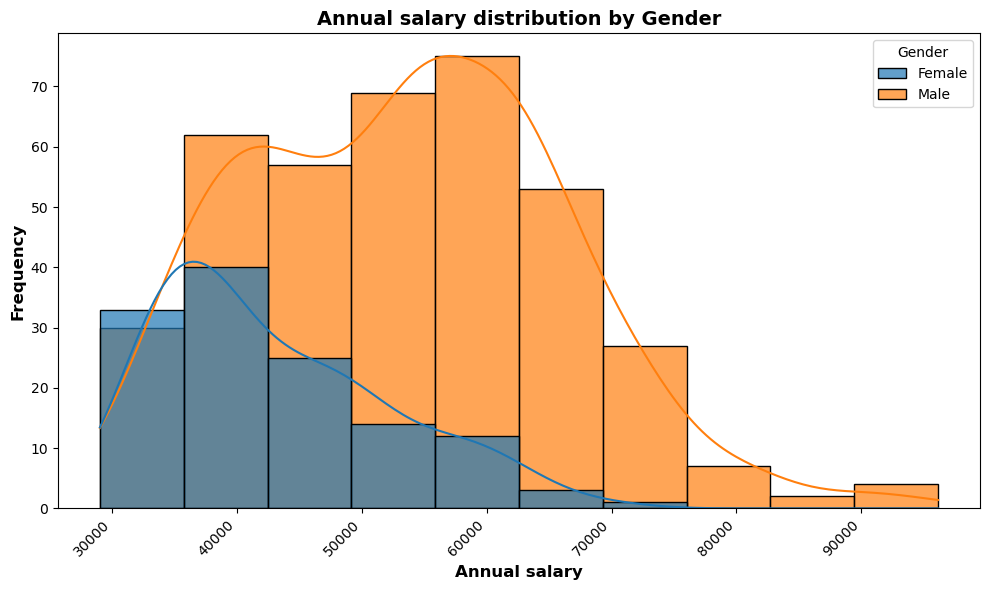

In [27]:
relationship_graph("Gender")

The male salary distribution appears to be more skewed to the right, while the female distribution is more concentrated in lower salary ranges.
Males dominate the higher salary ranges `$70,000`+, whereas males and females are more concentrated in the `$30,000–$60,000` range.

The peak for males is higher and occurs at a higher salary level compared to females.
This suggests that males tend to earn more on average than females, which could indicate a gender pay gap. But this cannot be said definitively as there is a lower number of females is represented compared to males.

Both distributions overlap in the mid-range (`$40,000–$60,000`), suggesting that a significant portion of both genders earn within this range.
However, fewer females earn salaries in the higher brackets, and their distribution tapers off much earlier than that of males.


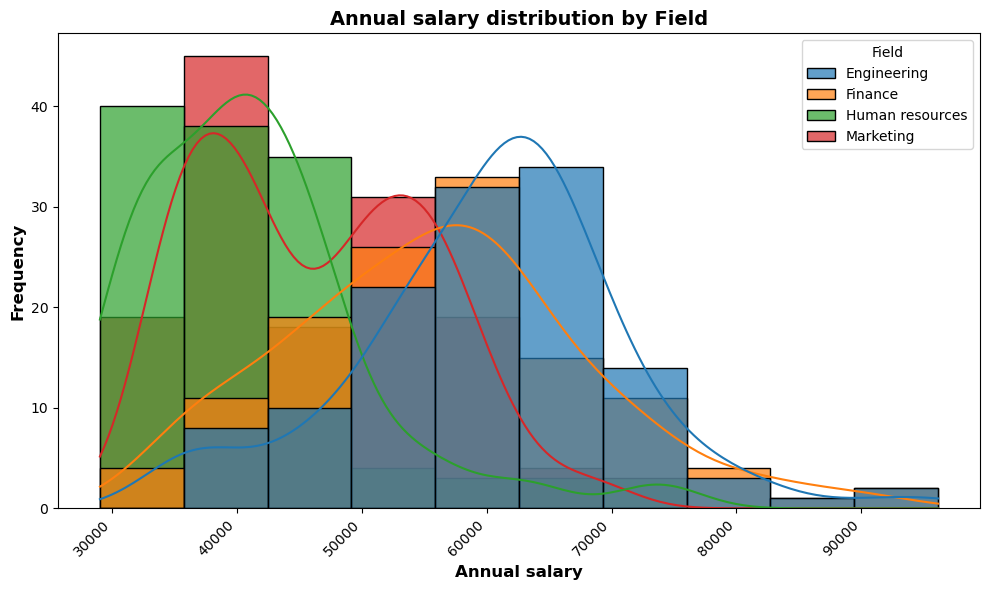

In [28]:
relationship_graph("Field")

The distribution for engineering salaries extends the farthest right (up to `$90,000+`), indicating that this field has the highest salaries overall.
It has a higher concentration of employees in the `$50,000–$80,000` range compared to other fields.

Finance salaries span a wide range, from around `$30,000 `to `$80,000`, with a significant number of employees earning around `$40,000–$70,000`.
The KDE curve suggests a gradual decline in frequency at higher salaries, indicating that some employees earn significantly more.

Human resources has the highest concentration in the `$30,000–$50,000` range, with very few salaries exceeding `$60,000`.
Marketing shows a similar pattern but has a slight right skew, indicating that a small number of employees earn higher salaries in this field.

HR and marketing salaries heavily overlap in the `$30,000–$50,000` range, making these two fields relatively comparable in salary structure.
Engineering has minimal overlap with HR and marketing but some overlap with finance in the mid-to-high range.

In [29]:
cleaned_df.drop(
    ["Has degree", "Has other post-secondary qualification"],
    axis=1,
    inplace=True,
)

The "Has degree" and "Has other post-secondary qualification" columns have been dropped, as their distributions do not exhibit comparable density. Some categories within these columns are underrepresented or lack sufficient observations, making it impractical to use them as reliable indicators of annual salary.

In [30]:
def convert_dummies(df):
    df["Field"] = pd.Categorical(
        df["Field"],
        categories=["Human resources", "Engineering", "Finance", "Marketing"],
        ordered=True,
    )
    df["Gender"] = pd.Categorical(
        df["Gender"],
        categories=["Female", "Male"],
        ordered=True,
    )
    df_encoded = pd.get_dummies(df, columns=["Field", "Gender"], drop_first=True)
    for col in df_encoded.select_dtypes(include=["bool"]).columns:
        df_encoded[col] = df_encoded[col].astype(int)
    return df_encoded


cleaned_df_encoded = convert_dummies(cleaned_df)
cleaned_df_encoded.head()

,Annual salary,Years of experince in prior field,Years worked in current field,Years worked at current rank,Market value,Position,Field_Engineering,Field_Finance,Field_Marketing,Gender_Male
0,53000.0,0,0,0,1.17,Junior employee,0,0,0,1
1,58000.0,1,0,0,1.24,Junior employee,0,1,0,1
2,45500.0,0,0,0,1.21,Junior employee,0,0,0,1
3,35782.0,0,2,1,0.99,Junior employee,0,0,1,1
4,34731.0,0,2,2,0.91,Junior employee,0,0,1,1


The `get_dummies` function has been applied to the "field" and "gender" features to allow for an equal comparison of their influence on salary. This ensures that each gender and field is weighted the same. The first column generated for each feature has been dropped to prevent multicollinearity issues when building the model.

In [31]:
encoder = OrdinalEncoder(categories=[['Junior employee', 'Manager', 'Executive']])
cleaned_df_encoded["Position"] = encoder.fit_transform(cleaned_df_encoded[["Position"]])
cleaned_df_encoded["Position"].unique()

array([0., 1., 2.])

`OrdinalEncoder` has been utilized to assign status to the different positions as they have an intrinsic ordinal hierachy. Junior employees has lowest value(0) and Executive has the highest value(2). Managers have a value of 1.

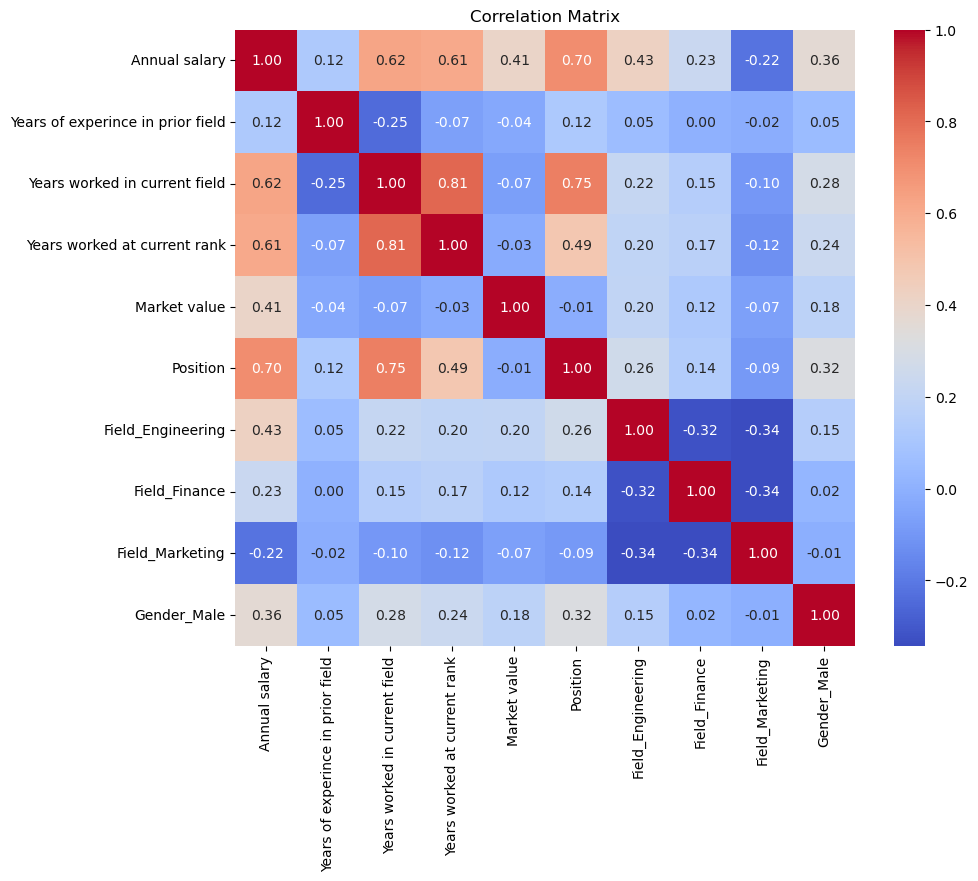

In [32]:
correlation_matrix = cleaned_df_encoded.corr(method="pearson")
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### 1. Strongest Positive Correlations with Annual Salary
- **Position (0.70)** has the highest correlation with salary, indicating that position of employeesplays a role in how much they earn.
- **Years worked in the current field (0.62)** and **Years worked at the current rank (0.61)** both show a strong positive correlation with salary, suggesting that experience within the current field and rank plays a major role in determining salary.
- **Employees in engineering (0.43)** tend to have higher salaries compared to other fields, although this correlation is slightly less than moderate.
- Employees associated with **higher market value (0.41)** companies tend to earn more, even though this correlation is slightly less than moderate.

### 2. Weak/Negative Correlations with Annual Salary
- **Years of experience in a prior field** show a very weak correlation with salary.

### 3. Relationships Between Other Variables
- **Years worked in current field & Years worked at current rank (0.81):** Employees who have worked in their current field for a long time also tend to stay at their rank longer.
- **Position & Years worked in current field (0.75):** employees with more years of experience in their field tend to have higher positions.

#### Higher salaries are strongly associated with **Position**, **years of experience**, and the **engineering field**.

#### Experience in the **same field** is an important factor in determining promotions and salary increases.

A function will be created to generate a table that displays the correlations between all features and the target variable, along with their significance levels. This table will help in understanding how each feature relates to the target and assess which relationships are statistically significant.

In [33]:
def p_value_calculator(df):
    correlations = []
    p_values = []
    feature_1 = []
    feature_2 = []
    for feature_1_var in df.columns:
        for feature_2_var in df.columns:
            if feature_1_var != feature_2_var:
                corr, p_value = pearsonr(df[feature_1_var], df[feature_2_var])
                p_values.append(p_value)
                correlations.append(corr)
                feature_1.append(feature_1_var)
                feature_2.append(feature_2_var)
    return pd.DataFrame(
        {
            "Feature 1": feature_1,
            "Feature 2": feature_2,
            "P value": p_values,
            "Correlation": correlations,
        }
    )


p_value_table = p_value_calculator(cleaned_df_encoded)
p_value_table.head()

,Feature 1,Feature 2,P value,Correlation
0,Annual salary,Years of experince in prior field,6.486052e-03,0.119927
1,Annual salary,Years worked in current field,1.257397e-56,0.623162
2,Annual salary,Years worked at current rank,7.787103e-54,0.610594
3,Annual salary,Market value,5.974692e-22,0.407204
4,Annual salary,Position,2.594373e-77,0.701386


The table is successfully created, providing a clear view of each feature's correlation with other features, as well as the corresponding p-value. This will be very useful for identifying the most influential features and understanding the relationships between variables.

The table has been filtered to isolate potential features by focusing on those that show a moderate or strong correlation with the annual salary. This approach highlights the most relevant variables that are likely to have a meaningful impact on predicting salary.

In [34]:
potential_features = p_value_table[
    (p_value_table["P value"] < 0.05)
    & ((p_value_table["Correlation"] > 0.3) | (p_value_table["Correlation"] < -0.3))
    & ((p_value_table["Feature 1"] == "Annual salary"))
]
potential_features

,Feature 1,Feature 2,P value,Correlation
1,Annual salary,Years worked in current field,1.257397e-56,0.623162
2,Annual salary,Years worked at current rank,7.787103e-54,0.610594
3,Annual salary,Market value,5.974692e-22,0.407204
4,Annual salary,Position,2.594373e-77,0.701386
5,Annual salary,Field_Engineering,4.580494e-24,0.425906
8,Annual salary,Gender_Male,2.609326e-17,0.361465


These features—`Years worked in current field`, `Years worked at current rank`, `Market value`, `Field_Engineering`, `Field_Engineering` and `Position`—appear to be highly relevant for predicting annual salary based on the correlations and their significance levels

Filtering to select features that are strongly correlated with each other significantly will help in choosing only the features that could lead to multicollinearity.

In [35]:
correlated_features = p_value_table[
    (p_value_table["P value"] < 0.05)
    & ((p_value_table["Correlation"] > 0.4) | (p_value_table["Correlation"] < -0.4))
    & (
        (p_value_table["Feature 1"] != "Annual salary")
        & (p_value_table["Feature 2"] != "Annual salary")
    )
]
correlated_features

,Feature 1,Feature 2,P value,Correlation
20,Years worked in current field,Years worked at current rank,1.337061e-122,0.813471
22,Years worked in current field,Position,9.962544e-93,0.746736
29,Years worked at current rank,Years worked in current field,1.337061e-122,0.813471
31,Years worked at current rank,Position,1.031451e-31,0.485210
47,Position,Years worked in current field,9.962544e-93,0.746736
48,Position,Years worked at current rank,1.031451e-31,0.485210


`Years worked in current field` is strongly correlated with the features `Years worked at current rank` and `Position`. `Position` is also significantly correlated with `Years at current rank`.

The features to be used for building the model is `Field_Engineering`, as it is significantly correlated to `Annual salary`. `Field_Finance` and `Field_Marketing` will also be used because these features are important for identifying salary of employee from the stand point of having to account for employees in different field from `Field_Engineering`."Years worked in current field", "Market value","Position" and "Years worked at current rank" also have a moderate to high correlation with annual salary. 

To investigate where multicolinearity problems amongst features, a VIF(Variance inflation factor) is to be made and decisions made on which features to discard or keep.

In [36]:
feature = cleaned_df_encoded[['Years worked at current rank',"Years worked in current field", "Field_Engineering", "Market value",'Position','Field_Finance','Field_Marketing']]
vif_data = pd.DataFrame()
vif_data["Feature"] = feature.columns
vif_data["VIF"] = [variance_inflation_factor(feature.values, i) for i in range(feature.shape[1])]
vif_data

,Feature,VIF
0,Years worked at current rank,7.488917
1,Years worked in current field,16.203902
2,Field_Engineering,2.518943
3,Market value,5.072018
4,Position,7.753365
5,Field_Finance,2.378982
6,Field_Marketing,2.167327


`Years worked at current rank`, `Years worked in current field`, `Market value` and `Position` have VIF values greater than 5, which implies that some of those features can be explained by other features. This calls for some features to be dropped or be combined to ensure that most variance can be explained by the fetures present.

In [37]:
cleaned_df_encoded['Experience value']=(cleaned_df_encoded['Years worked in current field']+cleaned_df_encoded['Years worked at current rank'])*cleaned_df_encoded['Market value']
feature = cleaned_df_encoded[["Experience value", "Field_Engineering",'Field_Finance','Field_Marketing','Position']]
vif_data = pd.DataFrame()
vif_data["Feature"] = feature.columns
vif_data["VIF"] = [variance_inflation_factor(feature.values, i) for i in range(feature.shape[1])]
vif_data

,Feature,VIF
0,Experience value,4.800389
1,Field_Engineering,1.915963
2,Field_Finance,1.759322
3,Field_Marketing,1.421950
4,Position,5.099667


`Experience value` has been defined as product of market value and sum of years worked in current rank and field. This signifies the value of the eperience the employee has to the company.

VIF analysis signifies that `Position` can still be explained by a combination of the other features, as a result, it is going to not be used in the model.

### Investigation linear regression applicability of the features

#### Linearity investigation between feature and target

Among the 5 potential features identified, it has already been observed through the scatterplots that the features `Years worked in current field`, `Years worked at current rank` and `Market value` show indications of a linear relationship with the target variable (Annual salary). The combination of these variables `Experience value` is also in turn expected to be linear. The linearity condition does not apply to the features `Field_Engineering`, `Field_Finance` and `Field_Marketing` as they are categorical features.

The features to be used for building the model are `Field_Engineering`, `Field_Finance`, `Field_Marketing` and `Experience value`. These are chosen because `Field_Engineering` is moderately correlated with `Annual salary`,the other fields are there to account for the rest of the other fields as they did not display even a moderate correlation with `Annual salary` and have no multicollinearity issues amongst each other. `Experience value` is chosen because it is a combination of features that capture the correlation of other features in explaining the target variable.

In [38]:
X = cleaned_df_encoded[
    ["Experience value","Field_Engineering",'Field_Finance','Field_Marketing']
]
y = cleaned_df_encoded["Annual salary"]

The features and target have been identified to split the dataframe accordingly.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2025
)

The dataset has been split into training and testing datasets using an 80/20 split. This was done by setting a random state value to ensure that the split remains consistent every time the notebook is run.

In [40]:
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()

The model has been built using the features discussed. Constants have been added to the training feature data to ensure that any deviations are captured, allowing the model to relate them to the target variable.

#### Normality check

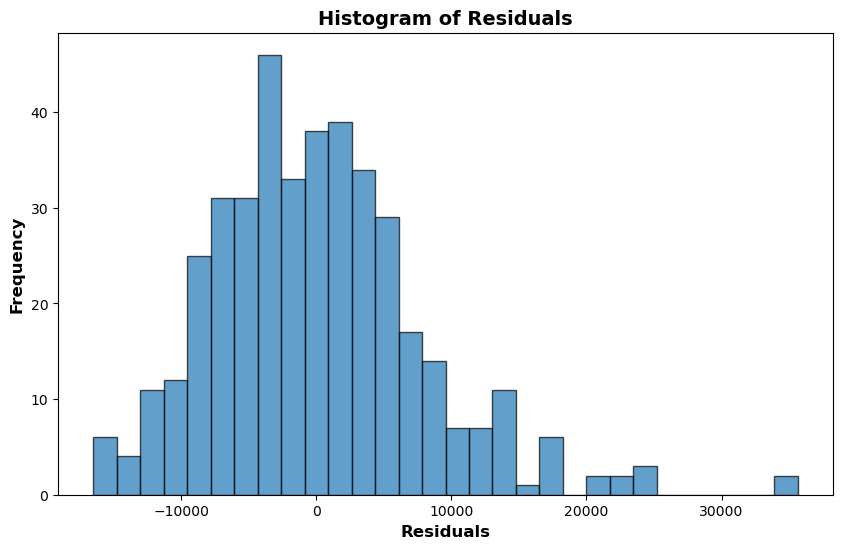

In [41]:
residuals = model.resid
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor="black", alpha=0.7)
plt.title("Histogram of Residuals", fontweight="bold", fontsize=14)
plt.xlabel("Residuals", fontweight="bold", fontsize=12)
plt.ylabel("Frequency", fontweight="bold", fontsize=12)
plt.show()

The plot appears to be slightly skewed to the right, suggesting that the normality condition may not be fully met. However, linear models are generally robust to a minor amount of non-normality, so the normality condition does not necessarily need to be strictly passed each time. Given that the data is relatively small, a **Shapiro-Wilk test** will be administered, assuming that the residuals are normally distributed, with a significance level of 5% to assess normality.

In [42]:
stats, p_value = shapiro(residuals)
alpha = 0.05
if p_value > alpha:
    print("Residuals are normal")
else:
    print("Residuals are not normal")

Residuals are not normal


The Shapiro-Wilk test has confirmed that the residuals are not normal.

#### Homogeniety check

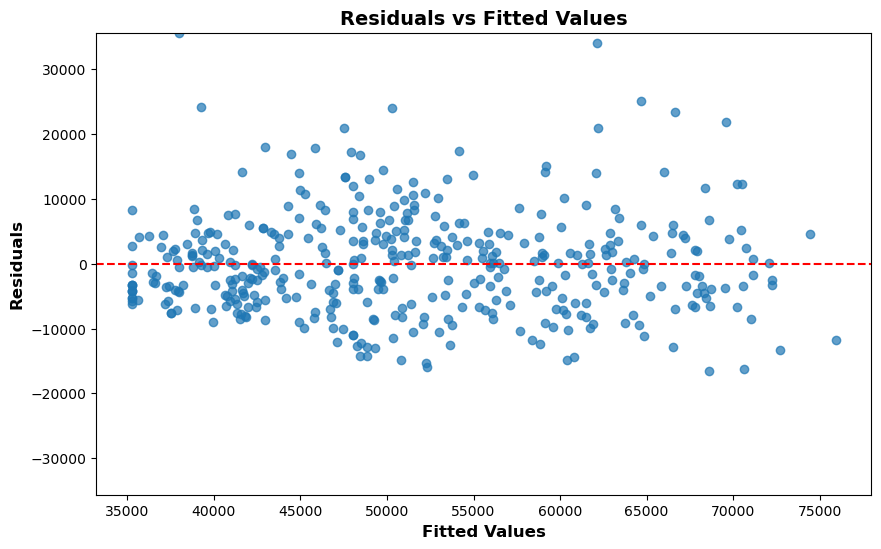

In [43]:
fitted_values = model.fittedvalues
plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals, alpha=0.7)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Fitted Values", fontweight="bold", fontsize=14)
plt.xlabel("Fitted Values", fontweight="bold", fontsize=12)
plt.ylabel("Residuals", fontweight="bold", fontsize=12)
plt.ylim(-max(max(residuals), min(residuals)), max(max(residuals), min(residuals)))
plt.show()

The plot does not display any clear pattern, linear or non-linear, and the residuals are spread evenly above and below the center. This suggests that a linear model can be used, as the conditions for linear fitting are met.

In [44]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Annual salary   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     167.0
Date:                Tue, 11 Mar 2025   Prob (F-statistic):           2.25e-84
Time:                        12:02:13   Log-Likelihood:                -4269.1
No. Observations:                 411   AIC:                             8548.
Df Residuals:                     406   BIC:                             8568.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              3.525e+04    865.195     40.740      0.000    3.35e+04    3.69e+04
Experience value    493.6523     28.438     17.359      0.000     437.749     549.556
Field_Engineering   1.28e+04   1168.355     10.954      0.000    1.05e+04    1.51e+04
Field_Finance      9693.6624   1169.488      8.289      0.000    7394.655     1.2e+04
Field_Marketing    4020.4659   1100.704      3.653      0.000    1856.675    6184.257
==============================================================================
Omnibus:                       60.920   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              106.627
Skew:                           0.870   Prob(JB):                     7.02e-24
Kurtosis:                       4.789   Cond. No.                         109.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The model accounts for 62% of the variance in the data.

According to the model:
- The minimum annual earning for any of the workers is about `$35,250`.
- For  increase in **Experience value**, there is a `$493.65` increase in annual salary.
- If an employee is in the **engineering field**, an additional `$12,800` is added to their annual salary.
- If an employee is in the **marketing field**, an additional `$4,020` is added to their annual salary.
- If an employee is in the **finance field**, an additional `$9,693` is added to their annual salary.

In [45]:
X_test = sm.add_constant(X_test)
y_test_predicted = model.predict(X_test)

The test features have had an added constant to ensure that the test data matches the format provided in the model. This data is then used to make predictions of the annual salary based on the model developed.

In [46]:
mean_absolute_error(y_test, y_test_predicted)

6125.098960221667

The mean absolute error signifies that the average error between the predicted salary and the actual salary is `$6,125`. This implies that, on average, the model is expected to predict the actual annual salary with a margin of error of `$6,125`.

In [47]:
mean_squared_error(y_test, y_test_predicted)

60578988.630911686

The mean squared error is approximately 60,6 million square dollars. Although these units may not be intuitive, it remains an important metric because the lower the value, the better the model performs in predicting actual annual salaries.

In [48]:
mean_squared_error(y_test, y_test_predicted, squared=False)

7783.250518318917

The root mean squared error is `$7,783`, which is the square root of the variance of the residuals. This provides an idea of the standard deviation of the errors in the model. It means that the bulk of the deviations from the predicted values by the model lie within `$7,783` of the actual annual salaries.

In [49]:
fitted_values = model.fittedvalues
residuals = model.resid
influence = model.get_influence()
leverage = influence.hat_matrix_diag

resid_mse = np.mean(residuals**2)

standardized_residuals = residuals / np.sqrt(resid_mse * (1 - leverage))
standardized_fitted_values = (fitted_values - np.mean(fitted_values)) / np.std(
    fitted_values
)

The code aims to assess the quality of the model’s fit by looking at residuals, leverage, and influence of data points. It computes standardized residuals to identify potential outliers and assess the homoscedasticity of the residuals (constant variance). Standardized fitted values help in understanding the distribution and spread of predicted values across the dataset.

In [50]:
standardized_residuals

358    0.345295
413    1.806796
430   -0.298431
488   -0.394272
17     0.521767
         ...   
160   -1.959831
396   -0.246539
211    0.239814
323   -0.852359
504   -0.438225
Length: 411, dtype: float64

The standardized residuals seem to be less than 2 and greater than -2, which indicates that the predicted values are fairly close to the observed ones. This suggests that the model performs well.

In [51]:
standardized_fitted_values

358    0.177335
413   -0.636064
430   -0.908328
488   -0.431907
17    -1.555818
         ...   
160    0.093015
396   -1.459217
211    0.489809
323    1.635786
504    1.672964
Length: 411, dtype: float64

Standardized residuals seem to be below 2 and greater than -2, indicating that the values are well-centered around the mean and not widely spread.

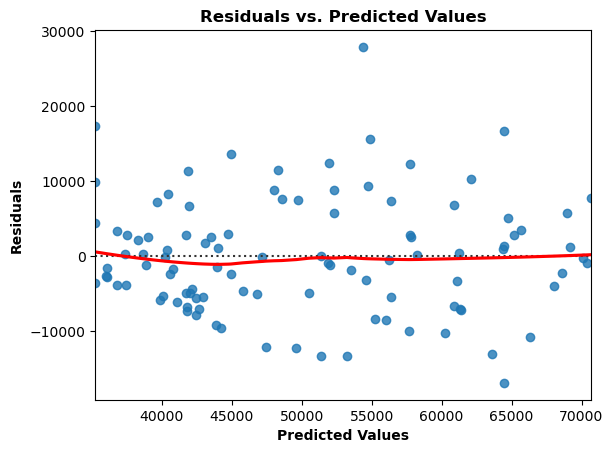

In [52]:
sns.residplot(x=y_test_predicted, y=y_test, lowess=True, line_kws={"color": "red"})
plt.xlabel("Predicted Values", fontweight="bold")
plt.ylabel("Residuals", fontweight="bold")
plt.title("Residuals vs. Predicted Values", fontweight="bold")
plt.show()

The red LOESS curve fluctuates slightly, suggesting some non-random structure. The slight curvature in the red line may indicate that the model is not capturing some aspect of the data correctly. This could be due to not capturing all relevant features that explain the data fully. The line appears to slightly underestimate salaries on the lower end.

The spread of residuals appears fairly consistent across different predicted values, though there are slightly larger residuals in some regions. If residual variance increased with predicted values (a funnel-like pattern), it would indicate **heteroscedasticity**, meaning errors are dependent on predicted values. In this case, there is no strong sign of heteroscedasticity, meaning the assumption of **homoscedasticity** (constant variance of residuals) seems reasonable. Some residuals deviate significantly from zero, which could suggest the presence of potential outliers.


In [53]:
kf = KFold(n_splits=20, shuffle=True, random_state=2025)
mse_scores = []
for train_index, test_index in kf.split(
    cleaned_df_encoded[
        [
            "Annual salary",
            "Experience value", "Field_Engineering",'Field_Finance','Field_Marketing'
        ]
    ]
):
    train, test = (
        cleaned_df_encoded[
            [
                "Annual salary",
            "Experience value",  "Field_Engineering",'Field_Finance','Field_Marketing'
            ]
        ].iloc[train_index],
        cleaned_df_encoded[
            [
                "Annual salary",
            "Experience value", "Field_Engineering",'Field_Finance','Field_Marketing'
            ]
        ].iloc[test_index],
    )

    X_train, y_train = train.drop(columns=["Annual salary"]), train["Annual salary"]
    X_test, y_test = test.drop(columns=["Annual salary"]), test["Annual salary"]

    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    model = sm.OLS(y_train, X_train).fit()

    y_pred = model.predict(X_test)

    mse_value = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse_value)
np.mean(mse_scores)

62658546.70169629

The test MSE (~60.6 Million) is slightly lower than the cross-validation MSE (~62.7 Million). The test MSE is approximately 3.3% lower than the cross validation MSE. Since the test error is similar or even slightly better, this suggests that the model generalizes well and is not overfitting.

The test performance aligns closely with the cross-validation performance, indicating that the model does not show signs of severe overfitting.

## Conclusion

A multivariate linear regression model was constructed to predict employee salaries using `Field_Engineering`, `Field_Finance`, `Field_Marketing` and `Experience value` as predictors. The distribution of variables and the relationship between features and salary were visualized to ensure the data was appropriate for regression modeling.

The regression analysis revealed that these factors strongly predict employee salaries, explaining a portion of the variance in the data. Model coefficients were interpreted to understand how salary changes with additional experience value and field of work.

By evaluating the model's performance on the test set and through cross-validation, accuracy across training and testing data was assessed using metrics like Root Mean Square Error (RMSE) and Mean Squared Error (MSE). This allowed us to assess the model's generalizability and confirm that there is no evidence of overfitting.

While the model demonstrated a clear relationship between experience value and field with annual salary, it became evident that these features alone cannot fully explain salary variations. The missing piece is reasonable, as the residuals are within about `$2,000` of the actual annual salary. The model performs reasonably well, and potential improvements could involve adding additional features, such as employee work records (e.g., "Employee of the Month").

This assignment provided valuable insights into the process of building, evaluating, and interpreting a regression model, emphasizing the importance of careful data preparation and critical assessment of model limitations. Future analyses should incorporate additional employee characteristics to create a more robust and comprehensive salary prediction model.